In [67]:
'''
!git clone https://github.com/mjirik/ndnoise
!pip install git+https://github.com/mjirik/io3d
!pip install git+https://github.com/mjirik/ndnoise
!pip install imma@git+https://github.com/mjirik/imma
!pip install sed3 loguru pydicom SimpleITK imma ruamel.yaml pandas
!pip install wandb
'''

'\n!git clone https://github.com/mjirik/ndnoise\n!pip install git+https://github.com/mjirik/io3d\n!pip install git+https://github.com/mjirik/ndnoise\n!pip install imma@git+https://github.com/mjirik/imma\n!pip install sed3 loguru pydicom SimpleITK imma ruamel.yaml pandas\n!pip install wandb\n'

In [68]:
# clear modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # silence warning logs
singularity_name = os.environ.get("SINGULARITY_NAME")
if singularity_name: print("Singularity:\t", singularity_name)    
print("version_info:\t", sys.version_info)
print("executable:\t",sys.executable)
print("pwd:\t\t", os.getcwd())

Singularity:	 TensorFlow:25.02-tf2-py3.SIF
version_info:	 sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
executable:	 /usr/bin/python
pwd:		 /auto/brno2/home/romova9/2D_to_3D


# Inicializace a data processing

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import ndnoise
import random
from numbers import Number
from typing import Optional
from pathlib import Path
import scipy
import cv2
import skimage.transform
import nibabel as nib
import h5py
import json

from PIL import Image
from loguru import logger
import io3d
import io3d.datasets
logger.enable("io3d")
logger.disable("io3d")

from methods_2D import image_generator_train_deepvesselnet, image_generator_train_3DIrcad, image_generator_train_Pigs

# Data

In [121]:
# Zvol task, vpřípadě potřeby uprav trénovací ids a typ úlohy
tasks = ["Deepvesselnet", "3DIrcad", "Pigs"]
axis = ["axial","coronal","sagital"]
smooth = 1

task = 2

In [122]:
# Struktura datasetu 3DIrcad
#-----------------------------------------------------------------------------------------------------------------------------------
#     DICOM_file - NEW_voxelsize = [1,1,1]        ORIG_data_shape      ORIG_data_voxelsize   RESIZED_data_shape
# ----------------------------------------------------------------------------------------------------------------------------------
portalvein = [1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]     # portalvein - zdola do jater
artery = [1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 17] 
venacava = [2, 11, 12, 13, 18]                                      # venacava - shora do jater
venoussystem = [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]
cevy = [1, 4, 5, 6, 7, 8, 9, 17]      # artery, portalvein, venoussystem
cevy1 = [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]   # portalvein, venoussystem
liver = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

s_artery = ['artery','artery'] # format [jmeno_modelu, slozky ...]
s_portalvein = ['portalvein', 'portalvein']
s_venacava = ['venacava', 'venacava']
s_venoussystem = ['venoussystem', 'venoussystem']
s_cevy = ['cevy', 'artery','portalvein','venoussystem']
s_cevy1 = ['cevy1', 'portalvein','venoussystem']
s_liver = ['liver', 'liver']

In [123]:
def datagenerator_train(task=2, batchsize=2, shape=(256, 256), axis_index=0):
    '''
    Generuje data pro trénování podle zadané úlohy v náhodném pořadí.
    axis_index - určuje v jakém pohledu mají být data řezána [axial, sagittal, coronal]
    '''
    if task == 0:
        directory = 'data/deepvesselnet/seg'
        all_dirs = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        ct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)

        train_generator = image_generator_train_deepvesselnet(ct_ids_train, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_deepvesselnet(ct_ids_test, batch_size=batchsize, sz=shape, axis=axis_index)

    elif task == 1:
        io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["_"] = "data/medical/orig/3Dircadb1/3Dircadb1.{id}/MASKS_DICOM/{data_type}/"
        io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["data3d"] = "data/medical/orig/3Dircadb1/3Dircadb1.{id}/PATIENT_DICOM/"
        io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)
        
        promenne = s_artery
        ct_ids_train = [1, 6, 7, 8, 9, 11, 12, 13, 17]
        ct_ids_test = [14, 5]

        train_generator = image_generator_train_3DIrcad(ct_ids_train, promenne=promenne, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_3DIrcad(ct_ids_test, promenne=promenne, batch_size=batchsize, sz=shape, axis=axis_index)

    elif task == 2:
        directory = "data/pilsen_pigs"
        ct_ids_train = ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven',
                        'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art',
                        'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']
        ct_ids_test = ['Tx021D_Ven', 'Tx040D_Art']

        train_generator = image_generator_train_Pigs(ct_ids_train, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_Pigs(ct_ids_test, batch_size=batchsize, sz=shape, axis=axis_index)

    else:
        print("Nastala chyba při generování dat!")
        return None, None

    return train_generator, test_generator, ct_ids_train, ct_ids_test

In [124]:
train_generator, test_generator, ct_ids_train, ct_ids_test = datagenerator_train(task=task, batchsize=2, shape=(256, 256), axis_index=0)

train_x, train_y = next(train_generator)
test_x, test_y = next(test_generator)

0.025737487 0.48887575 385898
0.0 1.0 2
0.0 1.0 256
0.0 1.0 2

(2, 256, 256, 3) (2, 256, 256, 2)
(2, 256, 256, 3) (2, 256, 256, 2)


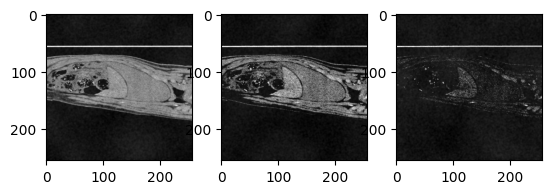

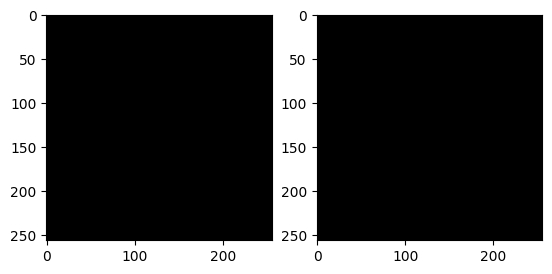

[[1. 1.]
 [1. 1.]]


In [125]:
print(np.min(train_x), np.max(train_x), len(np.unique(train_x)))
print(np.min(train_y), np.max(train_y), len(np.unique(train_y)))
print(np.min(test_x), np.max(test_x), len(np.unique(test_x)))
print(np.min(test_y), np.max(test_y), len(np.unique(test_y)))
print()
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

slice_ = 1

plt.subplot(131), plt.imshow(train_x[slice_,:,:,0], cmap='gray')
plt.subplot(132), plt.imshow(train_x[slice_,:,:,1], cmap='gray')
plt.subplot(133), plt.imshow(train_x[slice_,:,:,2], cmap='gray'), plt.show()

plt.subplot(121), plt.imshow(train_y[slice_,:,:,0], cmap='gray')
plt.subplot(122), plt.imshow(train_y[slice_,:,:,1], cmap='gray'), plt.show()

print(train_y[slice_,0:2,0:2,0])

# Train UNET

In [92]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num GPUs Available:  2


In [93]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers, mixed_precision
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Activation, Concatenate, BatchNormalization
#from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal

In [104]:
def get_unet(sz=(128, 128)):
    x = Input(sz[0], sz[1], 3)
    inputs = x

    #down sampling
    f = 8
    layers = []

    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64

    #bottleneck
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1

    #upsampling
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1


    #classification
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    outputs = Conv2D(2, 1, activation='sigmoid') (x)  # !!! 2 vektory na vystupu pro popredi i pozadi

    #model creation
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

project_name = "Log_to_wandb"

In [107]:
# Weighted_binary_crossentropy loss
from methods_2D import weighted_binary_crossentropy, dice_coef, precision, recall, f1_score

In [108]:
num_epoch = 6
epochs = 50
batch_size = 4 # 4 #16 
shape = (256, 256) # (256, 256) # (128, 128)
weighted_binary_crossentropy.weights = [500,10]
learning_rate = 0.001

In [ ]:
model = None
for ax in axis:
    text = tasks[task] + "_" + ax

    # Data generators
    train_generator, test_generator, ct_ids_train, ct_ids_test = datagenerator_train(task=task, batchsize=batch_size, shape=shape, axis_index=axis.index(ax))
    
    # Initialize W&B for this axis
    wandb.init(
        project=project_name,
        name=text,
        config={
            "experiment_name": text,
            "ct_ids_train": ct_ids_train,
            "ct_ids_test": ct_ids_test,
            "axis": ax,
            "shape": shape,
            "batch_size": batch_size,
            "epochs_per_step": epochs,
            "num_epoch_steps": num_epoch,
            "class_weights": weighted_binary_crossentropy.weights,
            "learning_rate": learning_rate,
            "model_architecture": "2D U-Net",
            "optimizer": "Adam",
            "loss_function": "binary_crossentropy",
            "metrics": ["IoU_background", "IoU_foreground", "DiceCoef", "Accuracy", "Precision", "Recall", "F1-score"]
        }
    )
    # Uložit run ID do souboru pro budoucí použití v případě dotrénování
    wandb_log = f"model_final/{text}.txt"
    os.makedirs(os.path.dirname(wandb_log), exist_ok=True) # Make directory if does not exists
    with open(wandb_log, "w") as f:
        f.write(wandb.run.id)
    
    # Calculate steps per epoch
    avg_slice_number = batch_size
    train_steps = (avg_slice_number * len(ct_ids_train)) // batch_size
    test_steps = (avg_slice_number * len(ct_ids_test)) // batch_size
    
    # Create the model inside the strategy's scope
    with strategy.scope():      
        # For Retrain load model
        '''
        # Load the model with custom objects
        custom_objects = {
            "dice_coef": dice_coef,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }
        model = tf.keras.models.load_model(f"model/{text}.h5", custom_objects=custom_objects)
        '''        
        # New model - možno přidat rozměr
        model = get_unet()     
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7),
            loss=weighted_binary_crossentropy,
            metrics=[
                tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0], name="iou_background"),
                tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1], name="iou_foreground"),
                dice_coef,
                tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                precision,
                recall,
                f1_score
            ]
        )
    
    # Train the model
    for i in range(num_epoch):
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=train_steps,
            validation_data=test_generator,
            validation_steps=test_steps,
            verbose=1,
            callbacks=[
                WandbCallback(
                    save_model=True,  #  True, pokud chceš ukládat model do W&B
                    log_weights=True,
                    log_gradients=False,  # True, pokud tě zajímají i gradienty
                    log_evaluation=True   # Vyhodnocení val datasetu
                )
            ]
        )
        # Save model
        model.save(f"model_final/{text}_{i}.h5")
        #wandb.save(f"model_final/{text}_{i}.h5")
        
    # Finish W&B run
    wandb.finish()

# Vyhodnoceni

In [126]:
import pandas as pd

In [ ]:
# Dictionary to collect results
# Format: {metric_name: {model_name: evaluation_value, ...}, ...}
results_dict = {}
axis = ["axial","coronal","sagital"]
modely = []
for ax in axis:
    # text = promene[0] + "_" + ax
    # text = "pilsen_pigs" + "_" + ax
    text = "pilsen_pigs_" + ax
    
    with strategy.scope():
        # Define custom objects
        custom_objects = {
            "dice_coef": dice_coef,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }
        
        # Load the model with custom objects
        model = tf.keras.models.load_model("model/" + text + '.h5', custom_objects=custom_objects)    
    modely.append(model)
    
    # Prepare the data generators
    train_generator, test_generator, ct_ids_train, ct_ids_test = datagenerator_train(task=task, batchsize=batch_size, shape=shape, axis_index=axis.index(ax))
    
    # Calculate steps per epoch (using batch_size; adjust if needed)
    avg_slice_number = batch_size  
    train_steps = (avg_slice_number * len(ct_ids_train)) // batch_size
    test_steps = (avg_slice_number * len(ct_ids_test)) // batch_size
    
    # Evaluate the model
    evaluation = model.evaluate(
        test_generator,
        steps=test_steps,  
        verbose=1  
    )
    
    # Get metric names from the model
    metric_names = model.metrics_names  # e.g., ['loss', 'iou_background', ...]
    
    # Collect results for each metric
    for m, v in zip(metric_names, evaluation):
        if m not in results_dict:
            results_dict[m] = {}
        results_dict[m][text] = v

# Create a DataFrame with metrics as rows and model names as columns
metrics_df = pd.DataFrame(results_dict).transpose()
print("Summary of all models:")
print(metrics_df)

In [ ]:
# modely[1].summary()

# Vizualizace testových snímků

In [131]:
x_axial, y_axial = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=0))
x_coronal, y_coronal = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=1))
x_sagital, y_sagital = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=2))

print(x_axial.shape, y_axial.shape)
print(x_coronal.shape, y_coronal.shape)
print(x_sagital.shape, y_sagital.shape)

x = [x_axial, x_coronal, x_sagital]
y = [y_axial, y_coronal, y_sagital]
print("Puvodni velikost: ", new_shape)

(32, 256, 256, 3) (32, 256, 256, 2)
(32, 256, 256, 3) (32, 256, 256, 2)
(32, 256, 256, 3) (32, 256, 256, 2)


NameError: name 'new_shape' is not defined

In [ ]:
predpovedi = []
for i in range(3):
    print(axis[i])
    vyhodnoceni = modely[i].evaluate(x=x[i], y=y[i])
    predpovedi.append(modely[i].predict(x=x[i]))
    print(predpovedi[-1].shape)

for a in range(3):
    predpovedi[a][predpovedi[a]>=0.5] = 2
    predpovedi[a][predpovedi[a]<0.5] = 0
    predpovedi[a][predpovedi[a]==2] = 1

In [ ]:
print(len(x))
print(x[0].shape)
print(x[1].shape)
print(x[2].shape)

In [ ]:
slice_ = [15,15,15]

for i in range(3):
    print(axis[i])  

    plt.figure(figsize=(16, 4))  # width=16 inches, height=4 inches

    plt.subplot(1, 4, 1)
    plt.imshow(x[i][slice_[i], :, :, 0], cmap="gray")
    plt.contour(y[i][slice_[i], :, :, 0], colors="red")
    plt.title("Input + GT contour")

    plt.subplot(1, 4, 2)
    plt.imshow(predpovedi[i][slice_[i], :, :, 0], cmap="gray")
    plt.title("Prediction - Channel 0")

    plt.subplot(1, 4, 3)
    plt.imshow(predpovedi[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Prediction - Channel 1")

    plt.subplot(1, 4, 4)
    plt.imshow(y[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Ground Truth - Channel 1")

    plt.tight_layout()
    plt.show()

In [ ]:
slice_ = [6, 5, 3]

for i in range(3):
    print(axis[i])  

    plt.figure(figsize=(16, 4))  # width=16 inches, height=4 inches

    plt.subplot(1, 4, 1)
    plt.imshow(x[i][slice_[i], :, :, 0], cmap="gray")
    plt.contour(y[i][slice_[i], :, :, 0], colors="red")
    plt.title("Input + GT contour")

    plt.subplot(1, 4, 2)
    plt.imshow(predpovedi[i][slice_[i], :, :, 0], cmap="gray")
    plt.title("Prediction - Channel 0")

    plt.subplot(1, 4, 3)
    plt.imshow(predpovedi[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Prediction - Channel 1")

    plt.subplot(1, 4, 4)
    plt.imshow(y[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Ground Truth - Channel 1")

    plt.tight_layout()
    plt.show()

In [ ]:
ax = 2
slice_ = 100
ground = 0

scan = x[ax][slice_,:,:,ground]
original = y[ax][slice_,:,:,ground]
prediction = predpovedi[ax][slice_,:,:,ground]
difference = original - prediction

plt.subplot(141), plt.imshow(scan, cmap="gray"), plt.title("scan")
plt.subplot(142), plt.imshow(original, cmap="gray"), plt.title("original")
plt.subplot(143), plt.imshow(prediction, cmap="gray"), plt.title("prediction")
plt.subplot(144), plt.imshow(difference, cmap="gray"), plt.title("difference")

print('original', np.unique(original))
print('prediction', np.unique(prediction))
print('difference', Counter(difference.flatten()))